<a href="https://colab.research.google.com/github/Kulikov17/MLDS_CV/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HW3. Шагающие человечки**

Хей-хей, сегодня будем делать интересные штуки. На семинаре мы обсудили, написали и потыкали `SSD`, в этом домашнем задании вам предстоит пойти дальше.

Благодаря ему вы попробуете:
 - собирать `Dataset` для детекционных задач
 - писать `train loop, eval` для детектора
 - немного кастомизировать детектор под свою задачу
 - разобраться с подсчетом метрик для детектора
 - возиться в куче `open-source` кода (ура!)
 - обучать и тестить `SSD` на своих классах
 - (бонусно) делать видео с результатами работы сети


 Да, прям настоящий `Computer vision` в этот раз!

В этом задании вы будете использовать реализацию `SSD`, написанную на семинаре (а значит его надо будет посмотреть, либо понять всё внимательным всматриванием в код)

**NB. Давайте сразу договоримся, что к коду должны прилагаться ваши осмысленные комментарии, а лишнего кода и текста тут не будет. Использовать могущество интернета можно, но указывайте ссылки откуда вы черпали помощь.**

**NB2. В этот раз будет много кода и немного страшно, но вы наверняка справитесь, надо только запланировать побольше времени на разбор.**

## **Весь код тут**

In [61]:
import os
import sys
import torch
import torchvision
import torch.nn.functional as F

from torch import nn
from math import sqrt
from torchvision import transforms
from torchvision.io import read_image
from PIL import Image, ImageDraw, ImageFont

import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings('ignore')

## **Часть 0. Вспоминаем код архитектуры и проверяем работоспособность детектора**

Комментариев тут нет, вы же уже разобрались :)

(Всю простыню можно просто скрыть стрелочкой из ячейки ниже)

### **Простыня кода**

In [28]:
## VGG Backbone
class VGGBase(nn.Module):
    def __init__(self):
        super(VGGBase, self).__init__()

        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)

        self.load_pretrained_layers()

    def forward(self, image):
        out = F.relu(self.conv1_1(image))
        out = F.relu(self.conv1_2(out))
        out = self.pool1(out)

        out = F.relu(self.conv2_1(out))
        out = F.relu(self.conv2_2(out))
        out = self.pool2(out)

        out = F.relu(self.conv3_1(out))
        out = F.relu(self.conv3_2(out))
        out = F.relu(self.conv3_3(out))
        out = self.pool3(out)

        out = F.relu(self.conv4_1(out))
        out = F.relu(self.conv4_2(out))
        out = F.relu(self.conv4_3(out))
        conv4_3_feats = out

        out = self.pool4(out)
        out = F.relu(self.conv5_1(out))
        out = F.relu(self.conv5_2(out))
        out = F.relu(self.conv5_3(out))
        out = self.pool5(out)
        out = F.relu(self.conv6(out))
        conv7_feats = F.relu(self.conv7(out))

        return conv4_3_feats, conv7_feats

    def load_pretrained_layers(self):
        state_dict = self.state_dict()
        param_names = list(state_dict.keys())

        pretrained_state_dict = torchvision.models.vgg16(pretrained=True).state_dict()
        pretrained_param_names = list(pretrained_state_dict.keys())

        for i, param in enumerate(param_names[:-4]):
            state_dict[param] = pretrained_state_dict[pretrained_param_names[i]]

        conv_fc6_weight = pretrained_state_dict['classifier.0.weight'].view(4096, 512, 7, 7)
        conv_fc6_bias = pretrained_state_dict['classifier.0.bias']

        state_dict['conv6.weight'] = decimate(conv_fc6_weight, m=[4, None, 3, 3])
        state_dict['conv6.bias'] = decimate(conv_fc6_bias, m=[4])

        conv_fc7_weight = pretrained_state_dict['classifier.3.weight'].view(4096, 4096, 1, 1)
        conv_fc7_bias = pretrained_state_dict['classifier.3.bias']

        state_dict['conv7.weight'] = decimate(conv_fc7_weight, m=[4, 4, None, None])
        state_dict['conv7.bias'] = decimate(conv_fc7_bias, m=[4])

        self.load_state_dict(state_dict)

        print("\n Loaded backbone.\n")

def decimate(tensor, m):
    assert tensor.dim() == len(m)
    for d in range(tensor.dim()):
        if m[d] is not None:
            tensor = tensor.index_select(dim=d, index=torch.arange(start=0, end=tensor.size(d), step=m[d]).long())
    return tensor

In [29]:
class AuxiliaryConvolutions(nn.Module):
    def __init__(self):
        super(AuxiliaryConvolutions, self).__init__()
        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, padding=0)
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)

        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, padding=0)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)

        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)

        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)

    def forward(self, conv7_feats):
        out = F.relu(self.conv8_1(conv7_feats))
        out = F.relu(self.conv8_2(out))
        conv8_2_feats = out

        out = F.relu(self.conv9_1(out))
        out = F.relu(self.conv9_2(out))
        conv9_2_feats = out

        out = F.relu(self.conv10_1(out))
        out = F.relu(self.conv10_2(out))
        conv10_2_feats = out

        out = F.relu(self.conv11_1(out))
        out = F.relu(self.conv11_2(out))
        conv11_2_feats = out

        return conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats


class PredictionConvolutions(nn.Module):
    def __init__(self, n_classes):
        super(PredictionConvolutions, self).__init__()
        self.n_classes = n_classes

        n_boxes = {'conv4_3': 4, 'conv7': 6, 'conv8_2': 6,
                   'conv9_2': 6, 'conv10_2': 4, 'conv11_2': 4}

        self.loc_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * 4, kernel_size=3, padding=1)
        self.loc_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * 4, kernel_size=3, padding=1)
        self.loc_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * 4, kernel_size=3, padding=1)

        self.cl_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * n_classes, kernel_size=3, padding=1)

    def forward(self, conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats):
        batch_size = conv4_3_feats.size(0)

        l_conv4_3 = self.loc_conv4_3(conv4_3_feats)
        l_conv4_3 = l_conv4_3.permute(0, 2, 3, 1).contiguous()
        l_conv4_3 = l_conv4_3.view(batch_size, -1, 4)

        l_conv7 = self.loc_conv7(conv7_feats)
        l_conv7 = l_conv7.permute(0, 2, 3, 1).contiguous()
        l_conv7 = l_conv7.view(batch_size, -1, 4)

        l_conv8_2 = self.loc_conv8_2(conv8_2_feats)
        l_conv8_2 = l_conv8_2.permute(0, 2, 3, 1).contiguous()
        l_conv8_2 = l_conv8_2.view(batch_size, -1, 4)

        l_conv9_2 = self.loc_conv9_2(conv9_2_feats)
        l_conv9_2 = l_conv9_2.permute(0, 2, 3, 1).contiguous()
        l_conv9_2 = l_conv9_2.view(batch_size, -1, 4)

        l_conv10_2 = self.loc_conv10_2(conv10_2_feats)
        l_conv10_2 = l_conv10_2.permute(0, 2, 3, 1).contiguous()
        l_conv10_2 = l_conv10_2.view(batch_size, -1, 4)

        l_conv11_2 = self.loc_conv11_2(conv11_2_feats)
        l_conv11_2 = l_conv11_2.permute(0, 2, 3, 1).contiguous()
        l_conv11_2 = l_conv11_2.view(batch_size, -1, 4)

        c_conv4_3 = self.cl_conv4_3(conv4_3_feats)
        c_conv4_3 = c_conv4_3.permute(0, 2, 3, 1).contiguous()
        c_conv4_3 = c_conv4_3.view(batch_size, -1, self.n_classes)

        c_conv7 = self.cl_conv7(conv7_feats)
        c_conv7 = c_conv7.permute(0, 2, 3, 1).contiguous()
        c_conv7 = c_conv7.view(batch_size, -1,self.n_classes)

        c_conv8_2 = self.cl_conv8_2(conv8_2_feats)
        c_conv8_2 = c_conv8_2.permute(0, 2, 3, 1).contiguous()
        c_conv8_2 = c_conv8_2.view(batch_size, -1, self.n_classes)

        c_conv9_2 = self.cl_conv9_2(conv9_2_feats)
        c_conv9_2 = c_conv9_2.permute(0, 2, 3, 1).contiguous()
        c_conv9_2 = c_conv9_2.view(batch_size, -1, self.n_classes)

        c_conv10_2 = self.cl_conv10_2(conv10_2_feats)
        c_conv10_2 = c_conv10_2.permute(0, 2, 3, 1).contiguous()
        c_conv10_2 = c_conv10_2.view(batch_size, -1, self.n_classes)

        c_conv11_2 = self.cl_conv11_2(conv11_2_feats)
        c_conv11_2 = c_conv11_2.permute(0, 2, 3, 1).contiguous()
        c_conv11_2 = c_conv11_2.view(batch_size, -1, self.n_classes)

        locs = torch.cat([l_conv4_3, l_conv7, l_conv8_2, l_conv9_2, l_conv10_2, l_conv11_2], dim=1)
        classes_scores = torch.cat([c_conv4_3, c_conv7, c_conv8_2, c_conv9_2, c_conv10_2, c_conv11_2], dim=1)

        return locs, classes_scores

In [30]:
class SSD300_(nn.Module):
    def __init__(self, n_classes):
        super(SSD300_, self).__init__()
        self.n_classes = n_classes

        self.base = VGGBase()
        self.aux_convs = AuxiliaryConvolutions()
        self.pred_convs = PredictionConvolutions(n_classes)

        self.priors_cxcy = self.create_prior_boxes()
        self.rescale_factors = nn.Parameter(torch.FloatTensor(1, 512, 1, 1))
        nn.init.constant_(self.rescale_factors, 20)

    def create_prior_boxes(self):
        fmap_dims = {'conv4_3': 38, 'conv7': 19, 'conv8_2': 10,
                     'conv9_2': 5, 'conv10_2': 3, 'conv11_2': 1}

        obj_scales = {'conv4_3': 0.1, 'conv7': 0.2, 'conv8_2': 0.375,
                      'conv9_2': 0.55, 'conv10_2': 0.725, 'conv11_2': 0.9}

        aspect_ratios = {'conv4_3': [1., 2., 0.5], 'conv7': [1., 2., 3., 0.5, 0.333],
                         'conv8_2': [1., 2., 3., 0.5, 0.333], 'conv9_2': [1., 2., 3., 0.5, 0.333],
                         'conv10_2': [1., 2., 0.5], 'conv11_2': [1., 2., 0.5]}

        prior_boxes = []
        fmaps = list(fmap_dims.keys())

        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]):
                for j in range(fmap_dims[fmap]):
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]

                    for ratio in aspect_ratios[fmap]:
                        prior_boxes.append([cx, cy, obj_scales[fmap] * sqrt(ratio), obj_scales[fmap] / sqrt(ratio)])

                        if ratio == 1.:
                            try:
                                additional_scale = sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])

                            except IndexError:
                                additional_scale = 1.
                            prior_boxes.append([cx, cy, additional_scale, additional_scale])

        prior_boxes = torch.FloatTensor(prior_boxes).to(device)
        prior_boxes.clamp_(0, 1)
        return prior_boxes

    def forward(self, image):
      conv4_3_feats, conv7_feats = self.base(image)

      norm = conv4_3_feats.pow(2).sum(dim=1, keepdim=True).sqrt()
      conv4_3_feats = conv4_3_feats / norm
      conv4_3_feats = conv4_3_feats * self.rescale_factors

      conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats = self.aux_convs(conv7_feats)

      locs, classes_scores = self.pred_convs(conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats,
                                              conv10_2_feats, conv11_2_feats)

      return locs, classes_scores

In [31]:
# Вспомогательные функции
#(x_min, y_min, x_max, y_max) -> (c_x, c_y, w, h)
def xy_to_cxcy(xy):
    return torch.cat([(xy[:, 2:] + xy[:, :2]) / 2,  # c_x, c_y
                      xy[:, 2:] - xy[:, :2]], 1)  # w, h

#(c_x, c_y, w, h) -> (x_min, y_min, x_max, y_max)
def cxcy_to_xy(cxcy):
    return torch.cat([cxcy[:, :2] - (cxcy[:, 2:] / 2),  # x_min, y_min
                      cxcy[:, :2] + (cxcy[:, 2:] / 2)], 1)  # x_max, y_max

#(c_x, c_y, w, h) -> (g_c_x, g_c_y,  g_w, g_h)
def cxcy_to_gcxgcy(cxcy, priors_cxcy):
    return torch.cat([(cxcy[:, :2] - priors_cxcy[:, :2]) / (priors_cxcy[:, 2:] / 10),
                      torch.log(cxcy[:, 2:] / priors_cxcy[:, 2:]) * 5], 1)

#(g_c_x, g_c_y,  g_w, g_h) -> (c_x, c_y, w, h)
def gcxgcy_to_cxcy(gcxgcy, priors_cxcy):
    return torch.cat([gcxgcy[:, :2] * priors_cxcy[:, 2:] / 10 + priors_cxcy[:, :2],
                      torch.exp(gcxgcy[:, 2:] / 5) * priors_cxcy[:, 2:]], 1)


def find_intersection(set_1, set_2):
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]


def find_jaccard_overlap(set_1, set_2):
    intersection = find_intersection(set_1, set_2)
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])

    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection
    return intersection / union

In [32]:
class SSD300(SSD300_):
  def detect_objects(self, predicted_locs, predicted_scores, min_score, max_overlap, top_k):
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)

        predicted_scores = F.softmax(predicted_scores, dim=2)

        all_images_boxes = list()
        all_images_labels = list()
        all_images_scores = list()

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        for i in range(batch_size):
            decoded_locs = cxcy_to_xy(gcxgcy_to_cxcy(predicted_locs[i], self.priors_cxcy))

            image_boxes = list()
            image_labels = list()
            image_scores = list()

            max_scores, best_label = predicted_scores[i].max(dim=1)

            for c in range(1, self.n_classes):
                class_scores = predicted_scores[i][:, c]
                score_above_min_score = class_scores > min_score
                n_above_min_score = score_above_min_score.sum().item()
                if n_above_min_score == 0:
                    continue

                class_scores = class_scores[score_above_min_score]
                class_decoded_locs = decoded_locs[score_above_min_score]

                class_scores, sort_ind = class_scores.sort(dim=0, descending=True)
                class_decoded_locs = class_decoded_locs[sort_ind]

                overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)

                # Non-Maximum Suppression (NMS)
                suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(device)

                for box in range(class_decoded_locs.size(0)):
                    if suppress[box] == 1:
                        continue

                    suppress = suppress | (overlap[box] > max_overlap)
                    suppress[box] = 0

                image_boxes.append(class_decoded_locs[1 - suppress])
                image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).to(device))
                image_scores.append(class_scores[1 - suppress])

            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
                image_labels.append(torch.LongTensor([0]).to(device))
                image_scores.append(torch.FloatTensor([0.]).to(device))

            image_boxes = torch.cat(image_boxes, dim=0)
            image_labels = torch.cat(image_labels, dim=0)
            image_scores = torch.cat(image_scores, dim=0)
            n_objects = image_scores.size(0)

            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k]
                image_boxes = image_boxes[sort_ind][:top_k]
                image_labels = image_labels[sort_ind][:top_k]

            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)

        return all_images_boxes, all_images_labels, all_images_scores

In [33]:
class MultiBoxLoss(nn.Module):
    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()

        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha

        self.smooth_l1 = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduce=False)

    def forward(self, predicted_locs, predicted_scores, boxes, labels):
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        n_classes = predicted_scores.size(2)

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).to(device)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).to(device)

        #каждую картинку отдельно обрабатываем
        for i in range(batch_size):
            n_objects = boxes[i].size(0)
            overlap = find_jaccard_overlap(boxes[i], self.priors_xy)
            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)
            _, prior_for_each_object = overlap.max(dim=1)
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).to(device)
            overlap_for_each_prior[prior_for_each_object] = 1.
            label_for_each_prior = labels[i][object_for_each_prior]
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0
            true_classes[i] = label_for_each_prior
            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy)  # (8732, 4)

        positive_priors = true_classes != 0

        # LOCALIZATION LOSS
        loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])  #scalar

        # CONFIDENCE LOSS
        n_positives = positive_priors.sum(dim=1)
        n_hard_negatives = self.neg_pos_ratio * n_positives

        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))
        conf_loss_all = conf_loss_all.view(batch_size, n_priors)
        conf_loss_pos = conf_loss_all[positive_priors]
        conf_loss_neg = conf_loss_all.clone()
        conf_loss_neg[positive_priors] = 0.
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)

        hardness_ranks = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg).to(device)
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]

        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()

        return conf_loss + self.alpha * loc_loss

In [34]:
# будем использовать модель предобученную на Pascal VOC, вот его классы
voc_labels = ('background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
              'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')

label_map = {k: v for v, k in enumerate(voc_labels)}
rev_label_map = {v: k for k, v in label_map.items()}

# Color map for bounding boxes of detected objects from https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
distinct_colors = ['#e6194b', '#3cb44b', '#ffe119', '#0082c8', '#f58231', '#911eb4', '#46f0f0', '#f032e6',
                   '#d2f53c', '#fabebe', '#008080', '#000080', '#aa6e28', '#fffac8', '#800000', '#aaffc3', '#808000',
                   '#ffd8b1', '#e6beff', '#808080', '#FFFFFF']
label_color_map = {k: distinct_colors[i] for i, k in enumerate(label_map.keys())}

### **Задание 0** (1 балл)

[Скачайте](https://drive.google.com/file/d/1ySBa0zbcd-59zan-8c0gwbmywd8dEq5h/view?usp=sharing) обученные на `Pascal VOC` веса для этой модели. Положите их себе на drive.

Подгрузите веса и протестите ssd на [одной из картинок](https://www.google.com/url?sa=i&url=https%3A%2F%2Fvk.com%2F%40shizpub-ochen-dovolnyi-pesel&psig=AOvVaw0ef1A0Qgda7GjhW3d9Fs-w&ust=1635250162815000&source=images&cd=vfe&ved=0CAsQjRxqFwoTCMiZmt_D5fMCFQAAAAAdAAAAABAE) (мы же хотим убедиться что с весами всё ок).

In [35]:
ssd = SSD300(21)
#ssd.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 74.8MB/s]



 Loaded backbone.



In [36]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [37]:
# указываем путь к данным
data_path = './gdrive/MyDrive/MLDS_CV/HW3'
checkpoint = torch.load(data_path + '/checkpoint_ssd300_pascal_voc.pth', map_location=device)

In [38]:
ssd.load_state_dict(checkpoint['state_dict'])
ssd.eval()


SSD300(
  (base): VGGBase(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), 

In [39]:
transform = transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
])

In [41]:
# тут считайте картинку с помощью PIL и подготовьте к подаче в детектор
original_image = Image.open('pesel.jpeg')
original_image_torch = transform(original_image).unsqueeze(0)

In [42]:
# получите предсказания детектора и используйте ssd.detect_objects() чтобы получить финальные боксы,
# для ssd порог на скор приемлемо брать в диапазоне 0.5-0.7, порог для nms в диапазоне 0.3-0.5
locs, scores = ssd(original_image_torch)
det_boxes, det_labels, det_scores = ssd.detect_objects(locs.detach(), scores.detach(), min_score=0.5, max_overlap=0.5, top_k=1)

In [43]:
# нам надо полученные относительные боксы накинуть на первоначальный размер изображения
original_dims = torch.FloatTensor([original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
det_boxes = det_boxes[0] * original_dims
det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]

In [44]:
det_labels

['dog']

In [45]:
# функция для рисования
def draw_boxes(original_image, det_boxes, det_labels):
  annotated_image = original_image.copy()
  draw = ImageDraw.Draw(annotated_image)
  font = ImageFont.load_default()

  for i in range(det_boxes.size(0)):
    # Boxes
    box_location = det_boxes[i].tolist()
    draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
    draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[det_labels[i]])

    # Text
    text_size = font.getsize(det_labels[i].upper())
    text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
    textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4., box_location[1]]
    draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
    draw.text(xy=text_location, text=det_labels[i].upper(), fill='white',font=font)

  return annotated_image

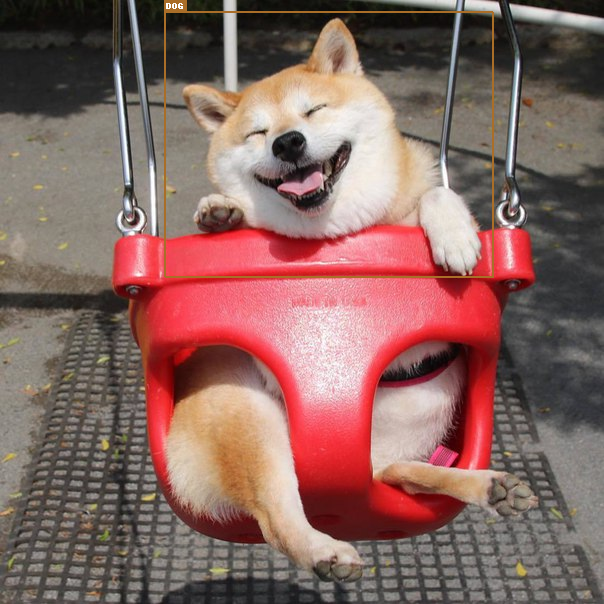

In [46]:
draw_boxes(original_image, det_boxes, det_labels)

Попробуйте поиграться с гиперпараметрами, чтобы получилось лучшее качество на этой картинке.

В целом результат не слишком великолепен - обучен детектор на небольшой базе `Pascal VOC`, мы используем не самую сильную его версию - `ssd300`, но даже с такими вводными у нас получится сделать интересное, let's get it started.

## **Часть 1. Копаемся в данных**

На этот раз  у нас будет небольшой датасет из гуляющих людей (вы удивитесь насколько небольшой). Данные можно скачать [здесь](https://drive.google.com/file/d/1_8mnenRzV6ylr7L29LuhQHKd82GNzU9y/view?usp=sharing).

Для того, чтобы учить сеть, нужен будет `Dataloader`, а значит и собственный `Dataset`. Чтобы собрать `Dataset`, надо понять как выглядят данные и аннотация, а также какие данные понадобятся вашей сетке для обучения. Данные будут не совсем типичные для задачи - у вас будут картинки и маски объектов, из масок вам самим придется сделать боксы, которые так жаждет наш `MultiBoxLoss`.

Данные уже разделены на `train` и `test`, никакого кровосмешения больше не делаем.

**NB**. Часть с копанием в данных приносит вам баллы, только если далее вы попробуете что-то осмысленное сделать с сеткой.











### **Задание 1** (1 балл)
Разархивируйте данные, загрузите и посмотрите на фото и соответствующие им маски (соответствие происходит явно по имени), напишите функцию, которая по маске высчитывает бокс, отрисуйте 4-5 фото с полученными боксами. Эту функцию будем использовать в `Dataset`.

In [47]:
!unzip -q  '/content/gdrive/MyDrive/MLDS_CV/HW3/PennFudanPed.zip' -d './'

In [48]:
train_img_dir='./PennFudanPed/Images/train'
test_img_dir='./PennFudanPed/Images/test'

In [83]:
def get_images(dir):
    images = []
    for filename in os.listdir(dir):
        if filename.endswith('.png'):
            images.append(filename)

    return sorted(images)

In [84]:
get_images(train_img_dir)

['FudanPed00001.png',
 'FudanPed00002.png',
 'FudanPed00003.png',
 'FudanPed00004.png',
 'FudanPed00005.png',
 'FudanPed00006.png',
 'FudanPed00007.png',
 'FudanPed00008.png',
 'FudanPed00009.png',
 'FudanPed00010.png',
 'FudanPed00011.png',
 'FudanPed00012.png',
 'FudanPed00013.png',
 'FudanPed00014.png',
 'FudanPed00015.png',
 'FudanPed00016.png',
 'FudanPed00017.png',
 'FudanPed00018.png',
 'FudanPed00019.png',
 'FudanPed00020.png',
 'FudanPed00021.png',
 'FudanPed00022.png',
 'FudanPed00023.png',
 'FudanPed00024.png',
 'FudanPed00025.png',
 'FudanPed00026.png',
 'FudanPed00027.png',
 'FudanPed00028.png',
 'FudanPed00029.png',
 'FudanPed00030.png',
 'FudanPed00031.png',
 'FudanPed00032.png',
 'FudanPed00033.png',
 'FudanPed00034.png',
 'FudanPed00035.png',
 'FudanPed00036.png',
 'FudanPed00037.png',
 'FudanPed00038.png',
 'FudanPed00039.png',
 'FudanPed00040.png',
 'FudanPed00041.png',
 'FudanPed00042.png',
 'FudanPed00043.png',
 'FudanPed00044.png',
 'FudanPed00045.png',
 'FudanPed

In [79]:
# делаю срез [1:] чтобы убрать пустую строку
train_images = sorted(list(map(lambda x: x.split('.')[0], os.listdir(train_img_dir))))[1:]
test_images = sorted(list(map(lambda x: x.split('.')[0], os.listdir(test_img_dir))))[1:]

In [52]:
def visualize(image, mask):
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    plt.title("Image")
    plt.imshow(image.permute(1, 2, 0))
    ax = plt.gca()
    for box in boxes:
      rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, edgecolor='red', linewidth=2)
      ax.add_patch(rect)
    plt.subplot(122)
    plt.title("Mask")
    plt.imshow(mask.permute(1, 2, 0))
    ax = plt.gca()
    for box in boxes:
      rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, edgecolor='red', linewidth=2)
      ax.add_patch(rect)

    plt.show()

In [55]:
image = read_image("./PennFudanPed/Images/test/FudanPed00050.png")
mask = read_image("./PennFudanPed/Masks/test/FudanPed00050_mask.png")

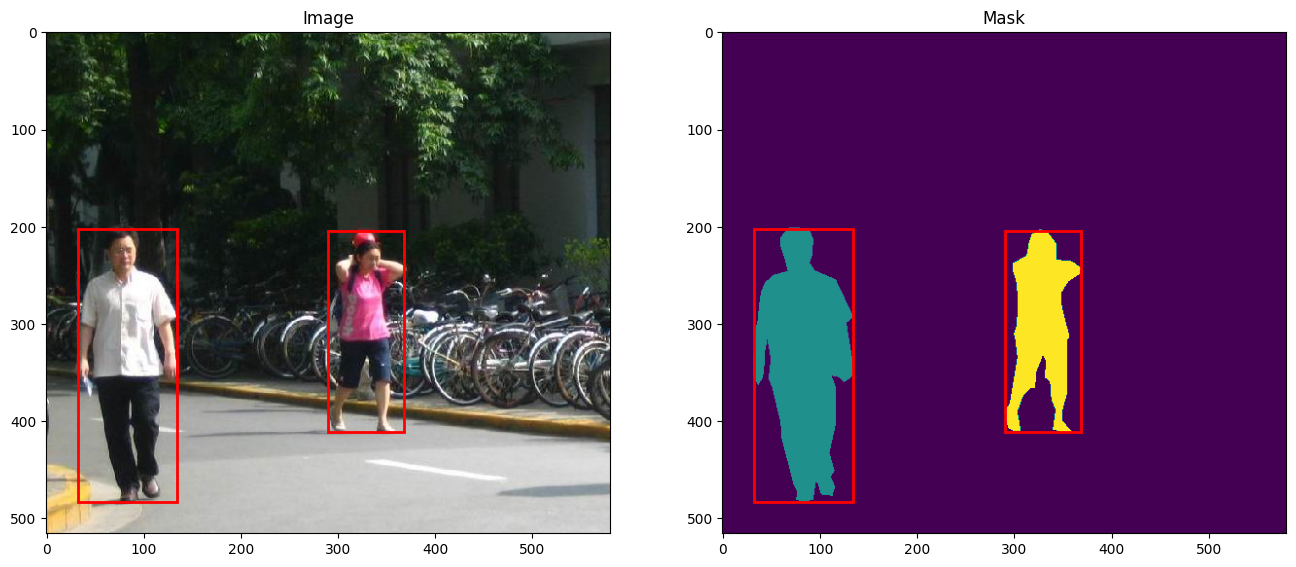

In [63]:
visualize(image, mask)

In [57]:
def masks_to_boxes(masks: torch.Tensor) -> torch.Tensor:
    if masks.numel() == 0:
        return torch.zeros((0, 4), device=masks.device, dtype=torch.float)

    n = masks.shape[0]

    bounding_boxes = torch.zeros((n, 4), device=masks.device, dtype=torch.float)

    for index, mask in enumerate(masks):
        y, x = torch.where(mask != 0)

        bounding_boxes[index, 0] = torch.min(x)
        bounding_boxes[index, 1] = torch.min(y)
        bounding_boxes[index, 2] = torch.max(x)
        bounding_boxes[index, 3] = torch.max(y)

    return bounding_boxes


In [92]:
mask = read_image("./PennFudanPed/Masks/test/FudanPed00050_mask.png")

In [93]:
mask

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

In [62]:
mask = read_image("./PennFudanPed/Masks/test/FudanPed00050_mask.png")
# instances are encoded as different colors
obj_ids = torch.unique(mask)
# first id is the background, so remove it
obj_ids = obj_ids[1:]
num_objs = len(obj_ids)

# split the color-encoded mask into a set
# of binary masks
masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

# get bounding box coordinates for each mask
boxes = masks_to_boxes(masks)

### **Задание 2** (1 балл)

Посмотрите, в каком виде данные нужны будут детектору и лоссу для работы. Напишите `Dataset`, заведите по нему loader-ы для трейна и теста, проверьте что всё ок.

In [59]:
def apply_transform(img, boxes):
    # transform задавали выше для все приложения
    new_img = transform(img)

    old_dims = torch.FloatTensor([img.width, img.height, img.width, img.height]).unsqueeze(0)
    new_boxes = boxes / old_dims

    return new_img, new_boxes

In [94]:
class PedestrianSet(Dataset):
    def __init__(self, root, is_train=True):
        self.root = root

        self.split = 'train' if is_train else 'test'

        self.imgs = get_images(os.path.join(root, 'Images', self.split))
        self.masks = get_images(os.path.join(root, 'Masks', self.split))


    def __getitem__(self, idx):
        img_path = os.path.join(self.root, 'Images', self.split, self.imgs[idx])
        mask_path = os.path.join(self.root, 'Masks', self.split, self.masks[idx])

        img = Image.open(img_path, mode='r').convert('RGB')
        mask = read_image(mask_path)

        # объекты закодированы разными цветами
        obj_ids = torch.unique(mask)
        # первый объект это фон, удаляем его
        obj_ids = obj_ids[1:]
        n_objects = len(obj_ids)

        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
        boxes = masks_to_boxes(masks) # (n_objects, 4)

        labels = torch.LongTensor(n_objects)  # (n_objects)

        img, boxes = apply_transform(img, boxes)

        return img, boxes, labels


    def __len__(self):
        return len(self.imgs)


    def collate_fn(self, batch):
        images = []
        boxes = []
        labels = []

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])

        images = torch.stack(images, dim=0)

        return images, boxes, labels

In [95]:
dataset_dir = './PennFudanPed'

train_dataset = PedestrianSet(dataset_dir)
test_dataset = PedestrianSet(dataset_dir, is_train=False)

In [96]:
batch_size = 8  # batch size
num_workers = 2

In [97]:
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=train_dataset.collate_fn,
                          num_workers=num_workers,
                          pin_memory=True)

In [98]:
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         collate_fn=test_dataset.collate_fn,
                         num_workers=num_workers,
                         pin_memory=True)

## **Часть 2. Копаемся в SSD**

Глобальная идея - мы хотим проверить следующую гипотезу: если взять предобученный детектор, оставить ему одну выходы только на один класс и затюнить его на моноклассовый датасет, то на тесте этого датасета мы получим лучше результат, чем на нем давал этот детектор первоначально.

### **Задание 3**. (1 балл)

Тогда сперва давайте получим результат детекции для класса `person` у первоначальной сети (никак не измененной) на `pedestrian test` сете.

Что для этого нужно:
 - получить предсказания детектора на всех фотках теста только для класса `person`
 - посчитать `АР` для класса `person` при `IoU=0.75` с gt


Ещё раз почитать про AP [тут](https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173).

Сразу скажу, что обычно используют код из [pycocotools](https://github.com/cocodataset/cocoapi/tree/master/PythonAPI/pycocotools). Во многих репозиториях вы увидите, что процедуры написаны специально для [coco](https://cocodataset.org/#home) - просто потому что это самый популярный датасет для детектирования и сегментации.

In [99]:
def inference(model, test_loader):
    model.eval()

    det_boxes = []
    det_labels = []
    det_scores = []
    true_boxes = []
    true_labels = []

    with torch.no_grad():
        for i, (images, boxes, labels) in enumerate(tqdm(test_loader, desc='Evaluating')):
            images = images.to(device)

            predicted_locs, predicted_scores = model(images)

            # Detect objects in SSD output
            det_boxes_batch, det_labels_batch, det_scores_batch = model.detect_objects(predicted_locs, predicted_scores,
                                                                                       min_score=0.01, max_overlap=0.45,
                                                                                       top_k=200)
            # Evaluation MUST be at min_score=0.01, max_overlap=0.45, top_k=200 for fair comparision with the paper's results and other repos

            # Store this batch's results for mAP calculation
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]

            det_boxes.extend(det_boxes_batch)
            det_labels.extend(det_labels_batch)
            det_scores.extend(det_scores_batch)
            true_boxes.extend(boxes)
            true_labels.extend(labels)


    return det_boxes, det_labels, det_scores, true_boxes, true_labels

In [100]:
det_boxes, det_labels, det_scores, true_boxes, true_labels = inference(ssd, test_loader)

Evaluating: 100%|██████████| 8/8 [01:40<00:00, 12.58s/it]


In [107]:
# это просто вариант реализации
# перед тем как скармливать сюда списки тензоров, положите их (тензоры) на cpu
def calculate_AP(det_boxes, det_scores, true_boxes, iou_threshold):
    """
    Calculate the Average Precision (AP) of detected objects of one class.

    :param det_boxes: list of tensors, one tensor for each image containing detected objects' bounding boxes
    :param det_scores: list of tensors, one tensor for each image containing detected objects' labels' scores
    :param true_boxes: list of tensors, one tensor for each image containing actual objects' bounding boxes
    :return: average precision (AP)
    """

    # делаем плоские списки для gt
    true_images = []
    for i in range(len(true_boxes)):
        true_images.extend([i] * true_boxes[i].size(0))

    true_images = torch.LongTensor(true_images)  # (n_objects), n_objects это количество всех gt на всех фотках
    true_boxes = torch.cat(true_boxes, dim=0)  # (n_objects, 4)
    n_оbjects = true_boxes.size(0)

    # будем отмечать какие из gt мы смогли задетектить (то есть сматчить с детекциями)
    # пока никакие
    true_class_boxes_detected = torch.zeros(n_оbjects, dtype=torch.uint8)  # (n_class_objects)

    # делаем плоские списки для детекций
    det_images = list()
    for i in range(len(det_boxes)):
        det_images.extend([i] * det_boxes[i].size(0))

    det_images = torch.LongTensor(det_images)  # (n_detections)
    det_boxes = torch.cat(det_boxes, dim=0)  # (n_detections, 4)
    det_scores = torch.cat(det_scores, dim=0)  # (n_detections)

    n_detections = det_boxes.size(0)
    if n_detections == 0:
        return 0

    # Сортируем детекции в порядке убывания скора
    det_scores, sort_ind = torch.sort(det_scores, dim=0, descending=True)  # (n_detections)
    det_images = det_images[sort_ind]  # (n_detections)
    det_boxes = det_boxes[sort_ind]  # (n_detections, 4)

    # Пробегаемся по отсортированному списку боксов и проверяем кто ТР, FP
    true_positives = torch.zeros((n_detections), dtype=torch.float)  # (n_detections)
    false_positives = torch.zeros((n_detections), dtype=torch.float)  # (n_detections)
    for d in range(n_detections):
        this_detection_box = det_boxes[d].unsqueeze(0)  # (1, 4)
        this_image = det_images[d]  # (), scalar

        # Выбираем нужные gts
        object_boxes = true_boxes[true_images == this_image]  # (n_objects_in_img)

        # если gt нету, то у нас FP
        if object_boxes.size(0) == 0:
            false_positives[d] = 1
            continue

        # пересекаем наш бокс со всеми gts и находим максимальное пересечение
        overlaps = find_jaccard_overlap(this_detection_box, object_boxes)  # (1, n_objects_in_img)
        max_overlap, ind = torch.max(overlaps.squeeze(0), dim=0)  # (), () - scalars

        # находим оригинальный индекс объекта чтобы правильно к матрице true_boxes_detected обратиться
        original_ind = torch.LongTensor(range(true_boxes.size(0)))[true_images == this_image][ind]

        # если max_overlap > threshold и gt свободен, то сматчились и это ТР
        if max_overlap.item() > iou_threshold:
          if true_class_boxes_detected[original_ind] == 0:
            true_positives[d] = 1
            true_class_boxes_detected[original_ind] = 1 # а этот gt теперь занят, к нему другим матчиться нельзя
          else:
            false_positives[d] = 1
        # если нет, то сорян
        else:
            false_positives[d] = 1

    # считаем кумулятивные TP/FP в порядке убывания скора
    cumul_true_positives = torch.cumsum(true_positives, dim=0)  # (n_detections)
    cumul_false_positives = torch.cumsum(false_positives, dim=0)  # (n_detections)

    # Теперь считаем кумулятивные pr/rec в порядке уменьшения скора
    cumul_precision = cumul_true_positives / (cumul_true_positives + cumul_false_positives + 1e-10)  # (n_detections)
    cumul_recall = cumul_true_positives / true_images.size(0)  # (n_detections)

    # делаем интерполяцию, чтобы функция была монотонно убывающей и у нас были такие типа bin-ы
    # дальше средняя высота по всем bin-ам и даст нам average precision
    recall_thresholds = torch.arange(start=0, end=1.01, step=.01).tolist()
    precisions = torch.zeros((len(recall_thresholds)), dtype=torch.float)

    for i, t in enumerate(recall_thresholds):
        recalls_above_t = cumul_recall >= t
        if recalls_above_t.any():
            precisions[i] = cumul_precision[recalls_above_t].max()
            #print(precisions[i])
        else:
            precisions[i] = 0.
            #print(precisions[i])

    return precisions.mean().item()

In [108]:
iou_threshold = 0.75

AP = calculate_AP(det_boxes, det_scores, true_boxes, iou_threshold)

print('Average Precision (AP): %.3f' % AP)

Average Precision (AP): 0.729


### **Задание 4**. (6 баллов)

А вот теперь будем играться с моноклассовой модификацией детектора.

1. Замените головы нашего `SSD300` так, чтобы теперь он детектировал только один класс. Вы можете создать новый экземпляр класса с другим параметром и аккуратно подтащить веса (или забить и не подтаскивать), либо уже у существующего `pretrained` детектора заменить необходимые слои (1 балл)

2. Подготовьте код для обучения и тестирования. **Явно пропишите свои функции train_epoch** (1 балла), **evaluate** (1 балл).

    Процедуры обучения и эвала можно посмотреть тут: [тык 1](https://github.com/pytorch/vision/blob/master/references/detection/engine.py), [тык 2](https://github.com/multimodallearning/pytorch-mask-rcnn/blob/master/model.py#L1736), [тык 3](https://github.com/pytorch/vision/blob/0467c9d74c9b34f91df905ed8cf8433de48d7fa5/references/detection/coco_eval.py#L19). А ещё можно покопаться в одной из самых известных (но чуть более сложной чем у нас) реализаций [ssd на pytorch](https://github.com/amdegroot/ssd.pytorch).

3. Поэкспериментируйте и постарайтесь выйти на хорошее качество на test. Попробуйте разные аугментации, lr, оптимайзеры, заморозку слоев и что ещё хочется (может быть самые смелые даже набор якорей попробуют поменять?). Напишите резюме - что получилсь, что нет, что зашло - а что не оч.

    Бенчмарки такие:

    **bbox AP@IoU=0.75 >=0.85** (1 балл)

    **bbox AP@IoU=0.75 >=0.9** (1 балл)

Написанное резюме по экспериментам - 1 балл.

Какой результат проверки гипотезы? Лучше ли тюнить детектор или и так было норм?
Напишите!

In [163]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [193]:
def train(model, train_loader, criterion, optimizer, epoch):
    model.train()  # training mode enables dropout

    losses = AverageMeter()  # loss

    for i, (images, boxes, labels) in enumerate(tqdm(train_loader)):
        print(labels)
        images = images.to(device)
        print(images.shape)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]

        print('pizda')
        predicted_locs, predicted_scores = model(images)

        print('jopa')

        print(predicted_locs, predicted_scores)
        loss = criterion(predicted_locs, predicted_scores, boxes, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.update(loss.item(), images.size(0))


        print('Epoch: {epoch}\tLoss {loss.val:.4f} ({loss.avg:.4f})'.format(epoch=epoch, loss=losses))

    del predicted_locs, predicted_scores, images, boxes, labels

    return losses


In [149]:
# our dataset has two classes only - background and person
ssd_pedestrian = SSD300(2)
ssd_pedestrian.base.load_state_dict(ssd.base.state_dict())
ssd_pedestrian.aux_convs.load_state_dict(ssd.aux_convs.state_dict())


 Loaded backbone.



<All keys matched successfully>

In [166]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [167]:
lr = 1e-3  # learning rate
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
epochs = 10

In [174]:
# Initialize the optimizer, with twice the default learning rate for biases, as in the original Caffe repo
biases = []
not_biases = []
for param_name, param in ssd_pedestrian.named_parameters():
    if param.requires_grad:
        if param_name.endswith('.bias'):
            biases.append(param)
        else:
            not_biases.append(param)

optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                                    lr=lr, momentum=momentum, weight_decay=weight_decay)

In [175]:
# Move to default device
ssd_pedestrian = ssd_pedestrian.to(device)
criterion = MultiBoxLoss(priors_cxcy=ssd_pedestrian.priors_cxcy).to(device)

In [1]:
for epoch in range(epochs):
    train(ssd_pedestrian, train_loader, criterion, optimizer, epoch)

NameError: name 'epochs' is not defined

## **Часть 3. Копаемся с видео (это бонусная часть!)**

Давайте теперь сделаем классный видос, чтобы все видели какие мы молодцы.
Видео для теста [живет тут](https://documents.epfl.ch/groups/c/cv/cvlab-pom-video3/www/terrace1-c3.avi).

### **Задание 5**. (2 балла)

В занятии про SORT мы увидели, как легко можно прикрутить трекер к вашим детекциям.

Попробуйте повторить этот трюк :)

Выбирайте трекер на свой вкус (кроме SORT, это неинтересно будет) и сделайте трекинг людей для видео, которое указано выше.

На видео у разных треков должны быть разные цвета, а также должны быть подписаны id (в занятии 6 можно посмотреть как работать с видео).  

## **А вот и конец дз. Вы просто великолепны!**